In [1]:
from analyze_images import *
from aberrations import *
import pyds9


In [4]:
configfile = 'Configs/taos2.yaml'
coll = Collimate(filename=configfile, configname="TAOS2")


In [5]:
ds9 = pyds9.DS9()

# Parameters

In [6]:
folder = '/data/piper0/bmcleod/2025-02-TAOS2Data/taosdata/mosaics/250115/'
minus_image = "site2_mosaic_fseq04_2068.fits"
plus_image = "site2_mosaic_fseq04_2088.fits"
minus_focus = 2068
plus_focus = 2088

## Preliminaries: determine how the aberrations are expected to vary with field angle and miscollimation state

array([[-2.76003196e-01, -1.37648829e-03],
       [ 7.51748095e+00, -1.10799976e+00]])

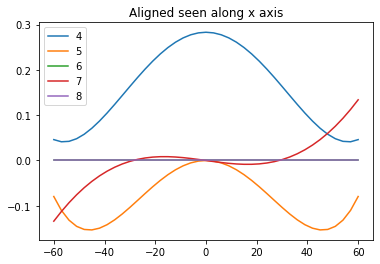

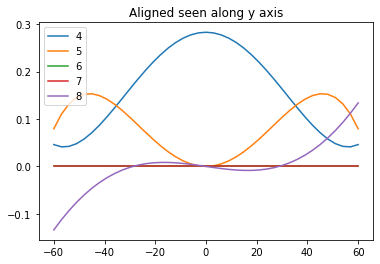

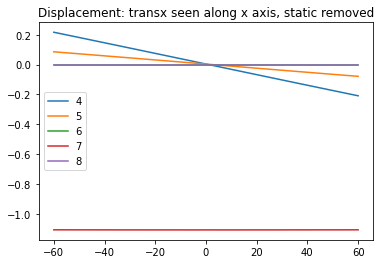

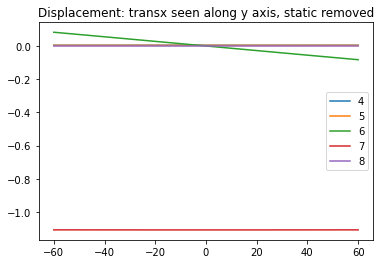

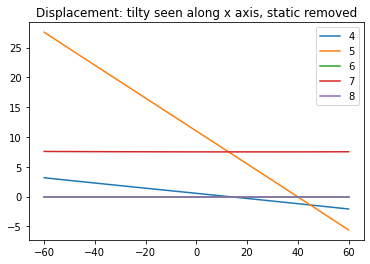

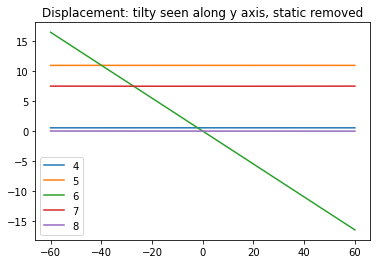

In [8]:
aber = Aberrations()
aber.read_zernike_data("Pokes/TAOS2/")

aber.fit_static_terms()
aber.compute_collimation_response_matrix()

In [6]:
# Display the image in ds9
ds9.set("file " + folder + minus_image)

1

### Record image locations using regions in the current ds9 frame
 
 Before executing the next cell, put regions on a set of ~9 stars well distributed over the image.
 Make sure the regions are well centered on the stars


In [12]:
# Get the star positions from ds9 and save in a file
#
do_the_ds9=True

locations_file = folder + os.path.splitext(minus_image)[0] + ".locations.txt"

if do_the_ds9:
    xy_locations = get_xy_from_ds9(ds9)
    print("Got these positions: ", xy_locations)
    save_star_locations(locations_file, xy_locations)

Got these positions:  [[8464.    891.  ]
 [4441.    480.  ]
 [ 910.    743.  ]
 [1213.   4117.  ]
 [ 845.   7527.  ]
 [4812.24 6865.44]
 [8485.8  6567.9 ]
 [9459.84 4184.88]
 [5329.32 3992.16]
 [8758.32 8816.7 ]]


### Read previously saved positions and extract postage stamps

In [10]:
locations_file = folder + os.path.splitext(minus_image)[0] + ".locations.txt"
xy_locations = load_star_locations(locations_file)
print(xy_locations)
coll.set_xy(xy_locations)
boxes_m = coll.extract_boxes_from_image(folder + minus_image)
boxes_p = coll.extract_boxes_from_image(folder + plus_image)

[[8464.    891.  ]
 [4441.    480.  ]
 [ 910.    743.  ]
 [1213.   4117.  ]
 [ 845.   7527.  ]
 [4812.24 6865.44]
 [8485.8  6567.9 ]
 [9459.84 4184.88]
 [5329.32 3992.16]
 [8758.32 8816.7 ]]


### Make an image for display purposes that shows all the postage stamps in the correct positions relative to each other, but magnified

In [11]:
magnification = 50

m_labels_region, m_layout = make_stamp_layout(boxes_m, xy_locations, magnification)
p_labels_region, p_layout = make_stamp_layout(boxes_p, xy_locations, magnification)

# Display in ds9
ds9.set("frame 1")
ds9.set_np2arr(m_layout)
ds9.set("regions", m_labels_region)

ds9.set("frame 2")
ds9.set_np2arr(p_layout)
ds9.set("regions", p_labels_region)

ds9.set("tile")
ds9.set("lock frame image")
ds9.set("lock scale")
ds9.set("lock colorbar")
ds9.set("scale zmax")
ds9.set("scale log")
ds9.set("zoom to fit")

1

In [12]:
results = coll.fit_images(boxes_m, boxes_p, minus_focus, plus_focus)

Processing 0
Processing 1
Processing 2
Processing 3
Processing 4
Processing 5
Processing 6
Processing 7
Processing 8
Processing 9


In [28]:
coll.show_stamp_layout_from_model_images(ds9, magnification=magnification)

# Redo this since we might be adding new frames the first time
ds9.set("lock frame image")
ds9.set("lock scale")
ds9.set("lock colorbar")
ds9.set("scale zmax")
ds9.set("scale log")
ds9.set("zoom to fit")

1

At this point you should look at the ds9 display and confirm that the model images in frames 3 and 4 are reasonable matches to the data in frames 1 and 2.  Sometimes there is an image where the model doesn't converge properly.  This can usually be resolved by rerunning fit_images().

In [ ]:
plot_coma(results)

Astigmatism fit:
  Constant terms: -0.30, -0.16
  Linear terms @ 60mm: 0.45, -1.20
  Quadratic term @ 60mm: 0.41
Focus fit
  Constant: 2076.90
  Linear @ 60mm: 0.30 -3.47
  Quadratic @ 60mm: 1.37
X coma fit
  Constant: 0.22
  Linear @ 60mm: -0.76
Y coma fit
  Constant: -0.45
  Linear @ 60mm: -0.71
(2, 10, 10)


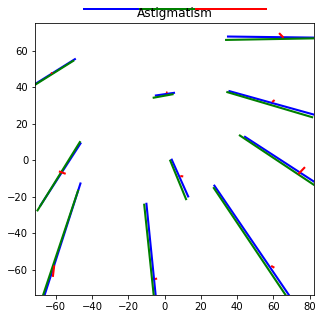

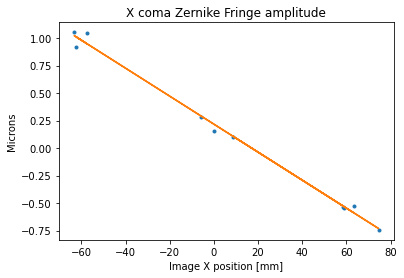

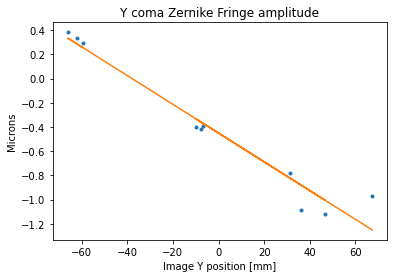

In [20]:
coll.fit_aberrations(results)

In [21]:
Tx, Ty, Ry, Rx = coll.determine_tilt_and_translation(coll.astigx, coll.astigy, coll.comax, coll.comay)

Translation X: -0.367 mm
Translation Y: 0.868 mm
Tilt about Y:  -0.025 deg
Tilt about X:  -0.068 deg


### Convert to actuator motions

In [22]:
# Distances from mirror vertex to upper and lower actuators
Du = 300 # Estimate from photo
Dl = 100 # Estimate from photo
turns_per_mm = 1 / (1/24 - 1/28) / 25.4 # Matt needs to confirm

xu = Tx - np.radians(Ry) * Du
xl = Tx - np.radians(Ry) * Dl
yu = Ty + np.radians(Rx) * Du
yl = Ty + np.radians(Rx) * Dl


print (xu, xl, yu, yl)


turns_west_upper = yu * turns_per_mm
turns_west_lower = yl * turns_per_mm
turns_south_upper = xu * turns_per_mm
turns_south_lower = xl * turns_per_mm

print(f"Turns west upper: {turns_west_upper:.2f}")
print(f"Turns west lower: {turns_west_lower:.2f}")
print(f"Turns south upper: {turns_south_upper:.2f}")
print(f"Turns south lower:{turns_south_lower:.2f}")

-0.011280210180525607 -0.24847931301259268 0.7358457034154978 0.8238050319212611
Turns west upper: 4.87
Turns west lower: 5.45
Turns south upper: -0.07
Turns south lower:-1.64


(2, 50, 50)
If collimated: True On-axis aberrations: [ 0.          0.          0.          0.         -0.29566123 -0.16443847
  0.          0.        ]


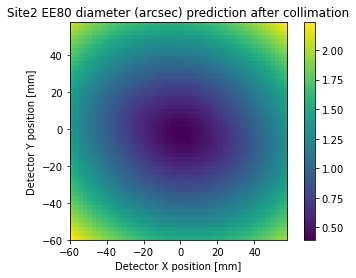

(2, 50, 50)
If collimated: False On-axis aberrations: [ 0.          0.          0.          0.         -0.29566123 -0.16443847
  0.21729423 -0.4506736 ]


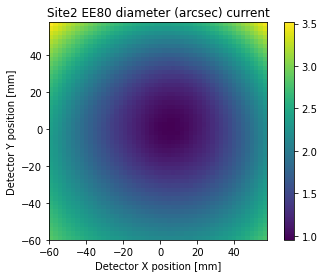

In [23]:
coll.make_image_quality_maps()
